In [1]:
!pip install langchain langchain_core langchain_community langgraph

In [2]:
from typing_extensions import TypedDict
class State(TypedDict):
  application: str
  summary: str
  experience_level: str
  skill_match : str
  response: str
  email:str

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
!pip install langchain_groq


In [5]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import PromptTemplate

In [7]:
def generate_summary(state: State) -> State:
  print("\nGenerating summary of resume : ")
  prompt = PromptTemplate(
      template= """You are a professional HR assistant. Summarize the given resume in a structured format, highlighting key details."
    "\n\n### Resume Summary:"
    "\n- Name: <Extract candidate's name>"
    "\n- Email: <Extract email, phone number, LinkedIn profile>"
    "\n- Key Skills: List major skills relevant to the job"
    "\n- Work Experience: Summarize key roles and responsibilities"
    "\n- Education: Mention highest degree and institution"
    "\n- Certifications (if any): List relevant certifications"
    "\n- Notable Achievements: Highlight any key accomplishments"
    "\n\n### Resume:"
      Application : {application}
      Summary : """,
      input_variables=["application"]
  )
  chain = prompt | llm
  summary = chain.invoke({"application": state["application"]}).content
  print(f"Summary : {summary}")
  return {"summary" : summary}


def categorize_experience(state: State) -> State:
  print("\nCategorizing the experience level of candidate : ")
  prompt = PromptTemplate(
      template="""Based on the following summary of job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'
      Application Summary : {summary}\n
      Experience Level : """,
      input_variables=["summary"]
  )
  chain = prompt | llm
  experience_level = chain.invoke({"summary": state["summary"]}).content
  print(f"Experience Level : {experience_level}")
  return {"experience_level" : experience_level}

def assess_skillset(state: State) -> State:
  print("\nAssessing the skillset of candidate : ")
  prompt = PromptTemplate(
      template="""Based on the summary of job application for a Python Developer, assess the candidate's skillset\n
      Respond with either 'Match' or 'No Match'
      Application Summary : {summary}\n
      Skill Match : """,
      input_variables=["summary"]
  )
  chain = prompt | llm
  skill_match = chain.invoke({"summary": state["summary"]}).content
  print(f"Skill Match : {skill_match}")
  return {"skill_match" : skill_match}

def extract_email(state: State) -> State:
  print("\nExtracting the email of candidate : ")
  prompt = PromptTemplate(
        template="""Extract the email address from the following job application summary.
        Respond with **only the email address** and nothing else. Do not include any extra words, explanations, or formatting.Do not include ** at beginning and ending also.You must include @ in email address.

        Application Summary: {summary}

        Email: """,
        input_variables=["summary"]
    )

  chain = prompt | llm
  email = chain.invoke({"summary": state["summary"]}).content.strip()
  print(f"Email : {email}")
  return {"email" : email}

def schedule_hr_interview(state: State) -> State:
    recipient_email = state["email"]
    subject = "Application Status Update"
    message = "Dear Candidate,\n\nThank you for your application. After careful consideration, we are here to inform you that you have been selected for the HR interview.\n\n"

    send_email(sender_email="01788497275ahon1984@gmail.com", recipient_email=recipient_email, subject=subject, message=message)

    return {"response": "Interview Selection Email"}

def escalate_to_recruiter(state: State) -> State:
    recipient_email = state["email"]
    subject = "Application Status Update"
    message = "Dear Candidate,\n\nThank you for your application. After careful consideration, we like to inform you that you are a senior-level developer but your skills don't match with our requirement.So we want to take an interview with you.\n\n"

    send_email(sender_email="01788497275ahon1984@gmail.com", recipient_email=recipient_email, subject=subject, message=message)

    return {"response": "Escalation to rcruiter"}

def reject_application(state: State) -> State:
    recipient_email = state["email"]
    subject = "Application Status Update"
    message = "Dear Candidate,\n\nThank you for your application. After careful consideration, we regret to inform you that you have not been selected for the role. We appreciate your interest in our company and wish you the best in your job search.\n\n"

    send_email(sender_email="01788497275ahon1984@gmail.com", recipient_email=recipient_email, subject=subject, message=message)

    return {"response": "Rejection email sent"}



In [8]:
!pip install yagmail


In [9]:
import os
import yagmail

def send_email(sender_email, recipient_email, subject, message):
    try:
        # Fetch the password from environment variables
        # sender_password = os.getenv('EMAIL_PASSWORD')
        sender_password = "vpqo qktv nqyv cxxy"

        if not sender_password:
            print("Error: EMAIL_PASSWORD is not set in environment variables.")
            return

        # Set up the yagmail client with your credentials
        yag = yagmail.SMTP(user=sender_email, password=sender_password)

        # Send the email
        yag.send(to=recipient_email, subject=subject, contents=message)

        print("Email sent successfully!")
    except Exception as e:
        print(f"Failed to send email. Error: {e}")




In [10]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

In [11]:
workflow.add_node("generate_summary", generate_summary)
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("extract_email", extract_email)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [12]:
def route_app(state: State) -> str:
  if(state["skill_match"] == "Match"):
    return "schedule_hr_interview"
  elif(state["experience_level"] == "Senior-level"):
    return "escalate_to_recruiter"
  else:
    return "reject_application"

In [13]:
workflow.add_edge("generate_summary", "categorize_experience")
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_edge("assess_skillset", "extract_email")
workflow.add_conditional_edges("extract_email", route_app)

In [14]:
workflow.add_edge(START, "generate_summary")
workflow.add_edge("extract_email", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)
workflow.add_edge("schedule_hr_interview", END)

In [15]:
app = workflow.compile()

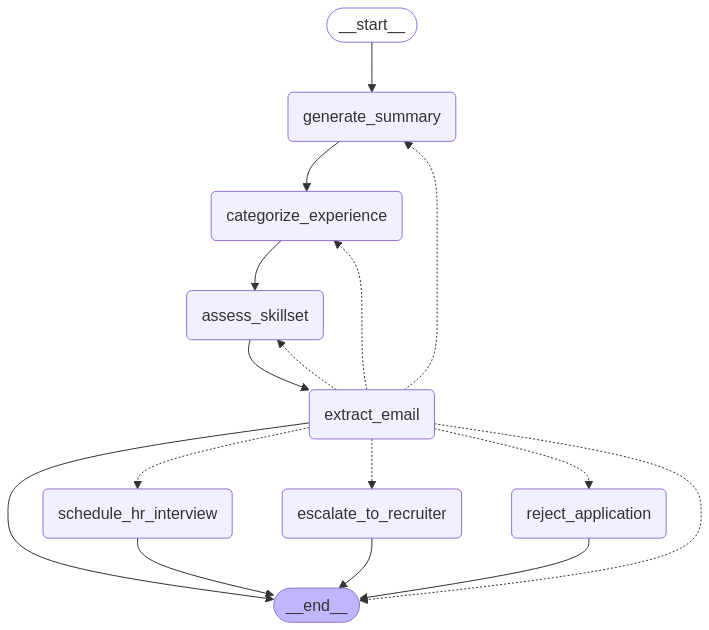

In [16]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [23]:
from google.colab import files
uploaded = files.upload()

Saving interview.pdf to interview.pdf


In [24]:
!pip install pymupdf
import fitz  # PyMuPDF

def extract_text(pdf_path):
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text() for page in doc])
    return text

In [25]:
pdf_path="interview.pdf"

In [26]:
output=extract_text(pdf_path)
print(output)

Muheet Rahi
§ | # muheetrahi@gmail.com | H +8801788497275
Profile
Dedicated Computer Science and Engineering (CSE) student at BUET, with a strong en-
thusiasm for Machine Learning, Deep Learning, Generative AI, and Large Language Models. Driven
by a passion for harnessing advanced AI technologies to solve real-world challenges, I am committed to
continuous learning, research, and innovation in the field.
Education
2022 – Present
BSc in Computer Science and Engineering, BUET Expected Graduation: March
2026
Currently in 3rd year (final examination ongoing)
Current CGPA: 3.92
2020
HSC Board Examination (Rangpur Cadet College)
GPA: 5.0
2018
SSC Board Examination (Rangpur Cadet College)
GPA: 5.0
Projects
Medical Chatbot
A Generative AI-based chatbot designed to provide medical assistance and information.
Built using
the open-source **LLaMA-2-7B** model for natural language understanding and response generation,
integrated with **Pinecone VectorDB** for efficient semantic search and retrieva

In [27]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "email" : results["email"],
      "response" : results["response"]
  }

In [28]:
results = run_candidate_screening(output)
print("\n\nComputed Results :")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Email: {results['email']}")
print(f"Response: {results['response']}")


Generating summary of resume : 
Summary : ## Muheet Rahi Resume Summary:

**Name:** Muheet Rahi

**Contact:** 
    * Email: muheetrahi@gmail.com
    * Phone: +8801788497275 
    * LinkedIn:  *Not Provided*

**Key Skills:**

* Programming Languages: C, C++, Python, Java, JavaScript, HTML, CSS
* Machine Learning: Scikit-Learn, Langchain, Langgraph
* Deep Learning
* Generative AI
* Large Language Models (LLaMA-2-7B)
* Frameworks: React, Spring Boot, Node.js
* Databases: MySQL, Vector Databases
* Tools: Shell Scripting, Cisco Packet Tracer

**Work Experience:**

* Python Developer (4 years experience) 

**Education:**

*  BSc in Computer Science and Engineering, BUET (Expected Graduation: March 2026)
    * Current CGPA: 3.92
* HSC Board Examination, Rangpur Cadet College (GPA: 5.0)
* SSC Board Examination, Rangpur Cadet College (GPA: 5.0)

**Notable Projects:**

* **Medical Chatbot:**  Generative AI chatbot using LLaMA-2-7B and Pinecone VectorDB for medical assistance. 
* **Potato Disease